In [1]:
import xarray as xr 
import numpy as np
from dask.distributed import Client
from dask_jobqueue import SLURMCluster
import pandas as pd
import dask.array as da
import glob 
import os

In [2]:
ls

climt1-54550.err  climt1-54551.out  Datasets/  notebooks/
climt1-54550.out  climt1-54660.err  main/      wrf/
climt1-54551.err  climt1-54660.out  MTH/


In [2]:
def create_dft(in_dir,arm_data=True):
    files = glob.glob(in_dir+os.sep+'*.nc')
    if len(files) == 0:
        files = glob.glob(in_dir+os.sep+'*.cdf')
        if len(files) == 0:
            raise Exception('No files Found')
        else:
            pass
    else:
        pass
    
    dft = pd.DataFrame(files,columns=['filepath'])
    dft['filename'] = dft['filepath'].str.split(os.sep).str[-1]
    
    if arm_data:
        dft['datetime'] = pd.to_datetime(dft['filename'].str.split(
            '.',
            expand=True).iloc[:, 2] + dft['filename'].str.split(
                '.',  expand=True).iloc[:, 3],format='%Y%m%d%H%M%S')
    return dft



In [3]:
cluster = SLURMCluster(
    job_name="climt1",          # --job-name
    cores=16,                     # Number of cores per task (adjust if needed)
    processes=16,                 # One process per task
    memory="100GB",               # --mem
    walltime="01:00:00",         # --time
    queue="med",               # --partition
    log_directory=".",           # Logs will be saved to the current directory
)

In [4]:
cluster.scale(4)

client = Client(cluster)

In [5]:
client

Connection method: Cluster object,Cluster type: dask_jobqueue.SLURMCluster
Dashboard: http://10.42.239.61:8787/status,
Dashboard: http://10.42.239.61:8787/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://10.42.239.61:41391,Workers: 0
Dashboard: http://10.42.239.61:8787/status,Total threads: 0
Started: Just now,Total memory: 0 B


In [6]:
file_test = '/home1/nalex2023/Datasets/interpsonde_manus/*.nc'

dset = xr.open_mfdataset(file_test,chunks={"time":100})

dset['time'] = dset['time'] + pd.Timedelta('10 hour')

In [7]:
dset['angle'] = (90 - np.degrees(np.arctan2(-dset['u_wind'], -dset['v_wind']))) % 360


dset['speed'] = np.sqrt(dset['u_wind']**2 + dset['v_wind']**2)



In [8]:
dset_computed = dset.compute()

KeyboardInterrupt: 

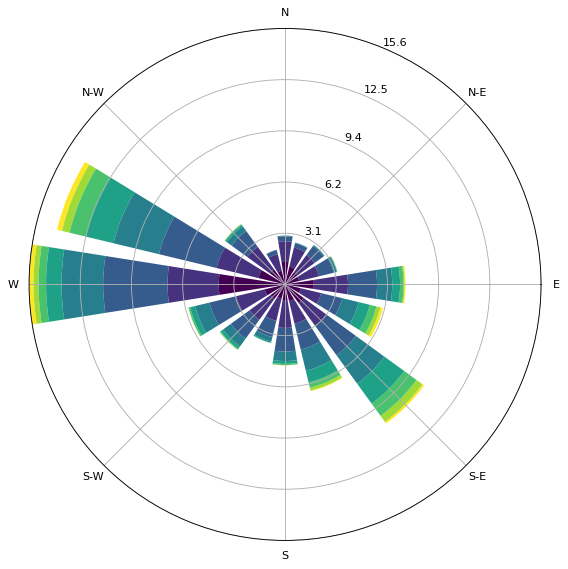

In [22]:
from windrose import WindroseAxes

dset_surface = dset_computed.sel(height=0,method='nearest')


ax = WindroseAxes.from_ax()

ax.bar(dset_surface['angle'],dset_surface['speed'],normed=True,bins=np.arange(0,8,1),nsector=16)


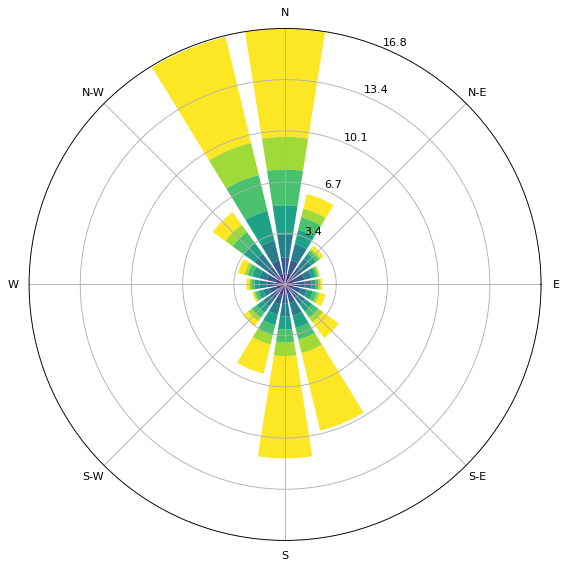

In [23]:
dset_upper = dset_computed.sel(height=2,method='nearest')

ax = WindroseAxes.from_ax()

ax.bar(dset_upper['angle'],dset_upper['speed'],normed=True,bins=np.arange(0,8,1),nsector=16)

In [10]:
met_fol = '/home1/nalex2023/Datasets/met_manus/*.cdf'

met_files = glob.glob(met_fol)

def prepro(ds):
    ds_new = ds[['wdir_vec_mean','wspd_vec_mean']]
    ds_new = ds_new.resample(time='1H').mean()
    return ds_new

met_dset = xr.open_mfdataset(met_files,preprocess=prepro,combine='by_coords')

met_dset

KeyboardInterrupt: 